# Ejercicio 1: Distribucion lluvia diaria
## Analizamos cómo el modelo representa aspectos de la distribución de una variable

En este tutorial vamos a explorar como es la distribución de probabilidades en el modelo para un punto:
- Vamos a seleccionar un punto
- Tomar datos diarios correspondiende a la semana 2
- Calcular la función de distribución de probabilidad y la función de distribución de probabilidad acumulada
En este caso vamos a trabajar con la variable precipitación

In [94]:
# Partimos importando los modulos a utilizar:
%matplotlib inline
import xarray as xr
import s3fs
import netCDF4
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
import os
import sys
import glob
import datetime
import matplotlib.pyplot as plt


Primero definimos algunas funciones que vamos a usar

In [95]:
# funcion para acomodar xarrays antes de concatenarlos
def preprocess_ds(ds):
    ds = ds.assign_coords(S= ds.time.values[0], M = ds.M.values)
    ds['time'] = ds.time.values - ds.time.values[0]
    ds = ds.rename({'time': 'leadtime'})
    return ds

# funcion para calcular la CDF de los datos
def calcular_cdf(datos):
    n = len(datos)
    x_ordenados = np.sort(datos)
    cdf = np.arange(1, n + 1) / n
    return x_ordenados, cdf

# función para obtener el segundo dato de cada grupo
def get_second_data(group):
    return group.isel(S=1)

Vamos a estudiar la distribucion para un punto, con la variable lluvia para las fechas alrededor del día 5/2/2018.

In [96]:
variable = 'rain'
lat = -29.18
lon = -58.07
os.system('mkdir -p ./tmp')
ref_date = datetime.datetime.strptime('20180502', "%Y%m%d")

Vamos a descargar de la base de datos de sissa los datos corregidos. Vamos a ver como se programa para seleccionar todas las fechas alrededor del 2 de mayo de cada año del período 2010-2019.
**Observación: si quieren trabajar en otro dominio para la misma variable, van a tener que nombrar a los archivos distinto o guardarlos en otra carpeta, no en tmp**

In [97]:
# DATOS CORREGIDOS
fs = s3fs.S3FileSystem(anon=True)
BUCKET_NAME = 'sissa-forecast-database'
tforecast = 'subseasonal'
modelo = 'GEFSv12_corr'
list_df = []
for i in np.arange(2010, 2020, 1): #loop sobre años
    loop_date = ref_date.replace(year=i) - timedelta(days=15) # reemplazo el año y arranco 15 días antes de la fecha
    while loop_date < (ref_date.replace(year=i) + timedelta(days=15)): # el loop es hasta 15 días despues
        if loop_date.weekday() == 2: # los pronos están disponibles los miercoles
            PATH = tforecast + '/' + modelo + '/' + variable + '/' + loop_date.strftime('%Y') + '/' + loop_date.strftime('%Y%m%d') + '/'            
            # Listamos todos los archivos dentro del bucket + PATH
            awsfiles = fs.ls('s3://' + BUCKET_NAME + '/' + PATH)
            df_m = []
            for ii, awsfile in enumerate(awsfiles):
                if not os.path.isfile('./tmp/corr_' + variable + '_' + loop_date.strftime('%Y%m%d') + '_' + str(ii) + '.nc4'):
                    print('Extrayendo datos del archivo:')
                    print(awsfile)
                    with fs.open(awsfile) as f:
                        gefs = xr.open_dataset(f)
                        gefs = gefs.sel(lat=lat, lon=lon, method='nearest')
                        gefs = gefs.assign_coords(M= ii)
                        ds = gefs[variable]
                        ds.to_netcdf('./tmp/corr_' + variable + '_' + loop_date.strftime('%Y%m%d') + '_' + str(ii) + '.nc4')
                        f.close()
        loop_date += timedelta(days=1)


Repetimos para los datos sin corregir

In [98]:
# DATOS SIN CORREGIR
fs = s3fs.S3FileSystem(anon=True)
BUCKET_NAME = 'sissa-forecast-database'
tforecast = 'subseasonal'
modelo = 'GEFSv12'
list_df = []
for i in np.arange(2010, 2020, 1):
    loop_date = ref_date.replace(year=i) - timedelta(days=15)
    while loop_date < (ref_date.replace(year=i) + timedelta(days=15)):
        if loop_date.weekday() == 2:
            PATH = tforecast + '/' + modelo + '/' + variable + '/' + loop_date.strftime('%Y') + '/' + loop_date.strftime('%Y%m%d') + '/'            
            # Listamos todos los archivos dentro del bucket + PATH
            awsfiles = fs.ls('s3://' + BUCKET_NAME + '/' + PATH)
            df_m = []
            for ii, awsfile in enumerate(awsfiles):
                if not os.path.isfile('./tmp/uncal_' + variable + '_' + loop_date.strftime('%Y%m%d') + '_' + str(ii) + '.nc4'):
                    print('Extrayendo datos del archivo:')
                    print(awsfile)
                    with fs.open(awsfile) as f:
                        gefs = xr.open_dataset(f)
                        gefs = gefs.sel(lat=lat, lon=lon, method='nearest')
                        gefs = gefs.assign_coords(M= ii)
                        ds = gefs[variable]
                        ds.to_netcdf('./tmp/uncal_' + variable + '_' + loop_date.strftime('%Y%m%d') + '_' + str(ii) + '.nc4')
                        f.close()
        loop_date += timedelta(days=1)


Repetimos para la base de datos observada

In [99]:
# Obtenemos los datos de ERA5
fs = s3fs.S3FileSystem(anon=True)
BUCKET_NAME = 'sissa-forecast-database'
tforecast = 'ERA5'
modelo = 'ERA5'
list_df = []
PATH = tforecast + '/' + variable 
for i in np.arange(2010, 2020, 1):
    awsfile = fs.ls('s3://' + BUCKET_NAME + '/' + PATH + '/' + str(i) + '.nc')
    with fs.open(awsfile[0]) as f:
        if not os.path.isfile('./tmp/era5_' + variable + '_' + str(i) + '.nc4'):
            era = xr.open_dataset(f)
            era = era.sel(latitude=lat, longitude=lon, method='nearest')
            era.to_netcdf('./tmp/era5_' + variable + '_' + str(i) + '.nc4')
        f.close()

Abrimos los datos observados y selecciono la segunda semana a patir de los miercoles alrededor de la fecha de interes para los años de estudio

In [100]:
ds_era = xr.open_mfdataset('./tmp/era5_' + variable + '*.nc4', engine='netcdf4', combine='nested', concat_dim='time')
print(ds_era)
ds_era = ds_era.compute()
for i in np.arange(2010, 2020, 1):
    loop_date = ref_date.replace(year=i) - timedelta(days=15)
    while loop_date < (ref_date.replace(year=i) + timedelta(days=15)):
        if loop_date.weekday() == 2:
            if not os.path.isfile('./tmp/' + variable + '_era5_' + loop_date.strftime('%Y%m%d') + '.nc4'):
                era = ds_era.sel(time= slice(loop_date + timedelta(days=8), loop_date + timedelta(days=14)))
                era['S'] = loop_date
                era['time'] = era['time'] - era['S']
                era.to_netcdf('./tmp/' + variable + '_era5_' + loop_date.strftime('%Y%m%d') + '.nc4')
        loop_date += timedelta(days=1)


<xarray.Dataset>
Dimensions:    (time: 3652)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2019-12-31
    latitude   float32 -29.25
    longitude  float32 -58.0
Data variables:
    rain       (time) float64 dask.array<chunksize=(365,), meta=np.ndarray>


Selecciono los datos corregidos y sin corregir del modelo. Vamos a hacerlo de tal manera de que la información quede bien organizada en función de la fecha y la cantidad de miembros del ensamble

In [101]:
list_ds = []
for i in np.arange(2010, 2020, 1):
    loop_date = ref_date.replace(year=i) - timedelta(days=15)
    while loop_date < (ref_date.replace(year=i) + timedelta(days=15)):
        if loop_date.weekday() == 2:
            archivos = glob.glob('./tmp/corr_' + variable + '*' +  loop_date.strftime('%Y%m%d') + '*.nc4')
            # Abre cada archivo con preprocesamiento y agrégalo a una lista de datasets
            datasets = [preprocess_ds(xr.open_dataset(archivo)) for archivo in archivos]
            datasets = xr.concat(datasets, dim='M')
            list_ds.append(datasets)
        loop_date += timedelta(days=1)            

ds_corr = xr.concat(list_ds, dim='S')
print(ds_corr)

<xarray.Dataset>
Dimensions:   (leadtime: 34, M: 11, S: 44)
Coordinates:
  * leadtime  (leadtime) timedelta64[ns] 0 days 1 days ... 32 days 33 days
  * M         (M) int64 0 1 2 3 4 5 6 7 8 9 10
    lat       float64 -29.25
    lon       float64 -58.0
  * S         (S) datetime64[ns] 2010-04-21 2010-04-28 ... 2019-05-08 2019-05-15
Data variables:
    rain      (S, M, leadtime) float64 5.942 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0


Selecciono la semana 2

In [102]:
# selecciono semana 2 (8-14 dias)
ds_corr_w2 = ds_corr.sel(leadtime=slice(np.timedelta64(8, 'D'), np.timedelta64(14, 'D')))
print(ds_corr_w2)

<xarray.Dataset>
Dimensions:   (leadtime: 7, M: 11, S: 44)
Coordinates:
  * leadtime  (leadtime) timedelta64[ns] 8 days 9 days ... 13 days 14 days
  * M         (M) int64 0 1 2 3 4 5 6 7 8 9 10
    lat       float64 -29.25
    lon       float64 -58.0
  * S         (S) datetime64[ns] 2010-04-21 2010-04-28 ... 2019-05-08 2019-05-15
Data variables:
    rain      (S, M, leadtime) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0


Repito para los datos corregidos

In [103]:
list_ds = []
for i in np.arange(2010, 2020, 1):
    loop_date = ref_date.replace(year=i) - timedelta(days=15)
    while loop_date < (ref_date.replace(year=i) + timedelta(days=15)):
        if loop_date.weekday() == 2:
            archivos = glob.glob('./tmp/uncal_' + variable + '*' +  loop_date.strftime('%Y%m%d') + '*.nc4')
            # Abre cada archivo con preprocesamiento y agrégalo a una lista de datasets
            datasets = [preprocess_ds(xr.open_dataset(archivo)) for archivo in archivos]
            datasets = xr.concat(datasets, dim='M')
            list_ds.append(datasets)
        loop_date += timedelta(days=1)            

ds_uncal = xr.concat(list_ds, dim='S')
print(ds_uncal)

<xarray.Dataset>
Dimensions:   (leadtime: 34, M: 11, S: 44)
Coordinates:
  * leadtime  (leadtime) timedelta64[ns] 0 days 1 days ... 32 days 33 days
  * M         (M) int64 0 1 2 3 4 5 6 7 8 9 10
    lat       float64 -29.25
    lon       float64 -58.0
  * S         (S) datetime64[ns] 2010-04-21 2010-04-28 ... 2019-05-08 2019-05-15
Data variables:
    rain      (S, M, leadtime) float64 4.0 0.3 0.0 0.0 ... 0.8498 0.0 0.45 0.25


In [104]:
# selecciono semana 2 (8-14 dias)
ds_uncal_w2 = ds_uncal.sel(leadtime=slice(np.timedelta64(8, 'D'), np.timedelta64(14, 'D')))
print(ds_uncal_w2)

<xarray.Dataset>
Dimensions:   (leadtime: 7, M: 11, S: 44)
Coordinates:
  * leadtime  (leadtime) timedelta64[ns] 8 days 9 days ... 13 days 14 days
  * M         (M) int64 0 1 2 3 4 5 6 7 8 9 10
    lat       float64 -29.25
    lon       float64 -58.0
  * S         (S) datetime64[ns] 2010-04-21 2010-04-28 ... 2019-05-08 2019-05-15
Data variables:
    rain      (S, M, leadtime) float64 0.0 0.0 0.0 0.0 0.0 ... 2.1 0.25 0.0 0.0


Abrimos los datos observados

In [105]:
ds_era = xr.open_mfdataset('./tmp/' + variable + '_era5_' + '*.nc4', engine='netcdf4', combine='nested', concat_dim=['S'])
print(ds_era)

<xarray.Dataset>
Dimensions:    (time: 7, S: 44)
Coordinates:
  * time       (time) timedelta64[ns] 8 days 9 days 10 days ... 13 days 14 days
    latitude   float32 -29.25
    longitude  float32 -58.0
  * S          (S) datetime64[ns] 2010-04-21 2010-04-28 ... 2019-05-15
Data variables:
    rain       (S, time) float64 dask.array<chunksize=(1, 7), meta=np.ndarray>


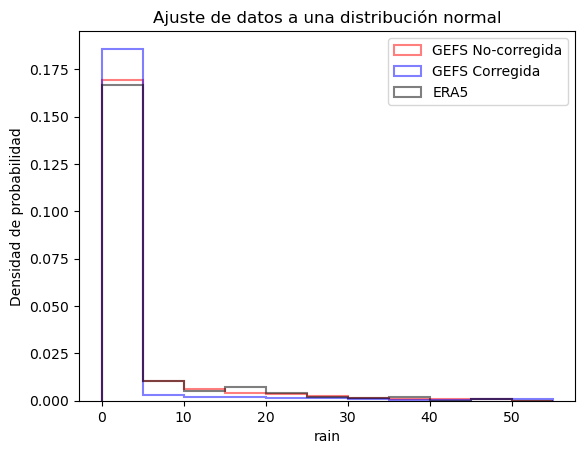

In [106]:
# Ajuste de los datos a una distribución normal
aux_uncal =ds_uncal_w2[variable].values.flat
aux_corr =ds_corr_w2[variable].values.flat
aux_era = ds_era[variable].values.flat[~np.isnan(ds_era[variable].values.flat)] 

bins = np.arange(0, 60, 5)

plt.hist(aux_uncal, bins, density=True, histtype='step', color='r', alpha=0.5, label='GEFS No-corregida', linewidth=1.5)
plt.hist(aux_corr, bins, density=True, histtype='step', color='b', alpha=0.5, label='GEFS Corregida', linewidth=1.5)
plt.hist(aux_era, bins, density=True, histtype='step', color='k', alpha=0.5, label='ERA5', linewidth=1.5)


plt.xlabel(variable)
plt.ylabel('Densidad de probabilidad')
plt.title('Ajuste de datos a una distribución normal')
plt.legend()
plt.show()

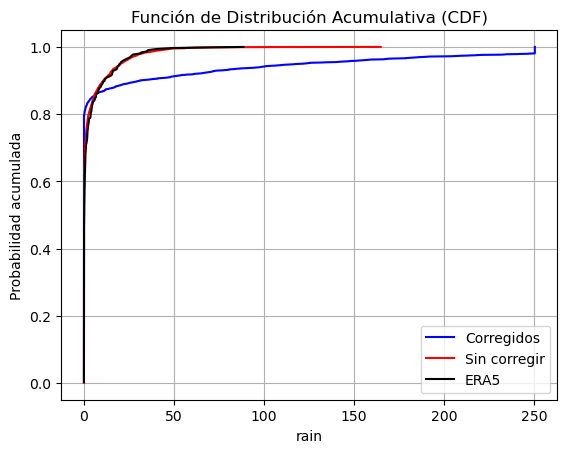

In [107]:
import numpy as np
import matplotlib.pyplot as plt

x_ordenados1, cdf1 = calcular_cdf(aux_corr)
x_ordenados2, cdf2 = calcular_cdf(aux_uncal)
x_ordenados3, cdf3 = calcular_cdf(aux_era)

# Plotear la CDF
plt.plot(x_ordenados1, cdf1, 'b', label='Corregidos')
plt.plot(x_ordenados2, cdf2, 'r', label='Sin corregir')
plt.plot(x_ordenados3, cdf3, 'k', label='ERA5')
plt.xlabel(variable)
plt.ylabel('Probabilidad acumulada')
plt.title('Función de Distribución Acumulativa (CDF)')
plt.legend()
plt.grid(True)
plt.show()


Ahora miramos la evolución de la lluvia acumulada para el segundo miercoles de mayo del registro. Vamos a ver cómo seleccionar los pronosticos inicializados esa segunda semana

In [108]:
#seleccionamos el me de mayo
ds_corr_w2 = ds_corr_w2.sum('leadtime', skipna=True).isel(S= ds_uncal_w2.S.dt.month==5)
ds_uncal_w2 = ds_uncal_w2.sum('leadtime', skipna=True).isel(S= ds_uncal_w2.S.dt.month==5)
ds_era = ds_era.sum('time', skipna=True).isel(S= ds_era.S.dt.month==5)


In [109]:
print(ds_corr_w2, ds_uncal_w2, ds_era)

<xarray.Dataset>
Dimensions:  (M: 11, S: 24)
Coordinates:
  * M        (M) int64 0 1 2 3 4 5 6 7 8 9 10
    lat      float64 -29.25
    lon      float64 -58.0
  * S        (S) datetime64[ns] 2010-05-05 2010-05-12 ... 2019-05-08 2019-05-15
Data variables:
    rain     (S, M) float64 0.0 14.01 30.04 0.0 0.0 ... 103.3 374.8 205.1 0.0 <xarray.Dataset>
Dimensions:  (M: 11, S: 24)
Coordinates:
  * M        (M) int64 0 1 2 3 4 5 6 7 8 9 10
    lat      float64 -29.25
    lon      float64 -58.0
  * S        (S) datetime64[ns] 2010-05-05 2010-05-12 ... 2019-05-08 2019-05-15
Data variables:
    rain     (S, M) float64 0.6497 8.999 16.05 1.25 ... 41.24 48.4 42.29 3.7 <xarray.Dataset>
Dimensions:    (S: 24)
Coordinates:
    latitude   float32 -29.25
    longitude  float32 -58.0
  * S          (S) datetime64[ns] 2010-05-05 2010-05-12 ... 2019-05-15
Data variables:
    rain       (S) float64 dask.array<chunksize=(1,), meta=np.ndarray>


In [110]:
# Selecciona el segundo miércoles de cada mes
ds_corr_w2_smier = ds_corr_w2.groupby('S.year').apply(get_second_data)
ds_uncal_w2_smier = ds_uncal_w2.groupby('S.year').apply(get_second_data)
ds_era_w2_smier = ds_era.groupby('S.year').apply(get_second_data)


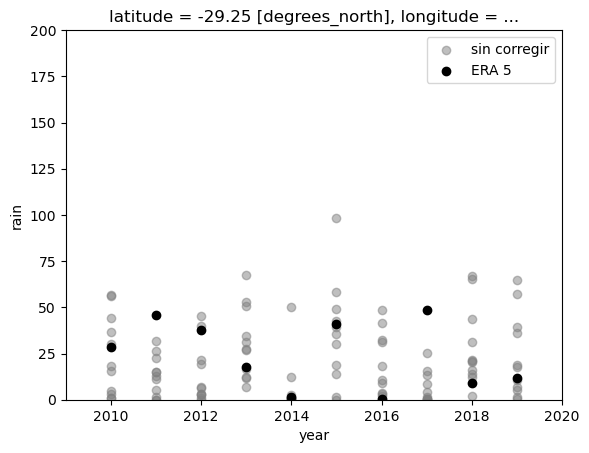

In [124]:
fig = plt.figure()
ds_uncal_w2_smier[variable].plot.scatter(x='year',color='gray', alpha=0.5, label='sin corregir')
ds_era_w2_smier[variable].plot.scatter(x='year', color='k', label='ERA 5')
plt.axis([2009, 2020, 0, 200])
plt.legend()
plt.savefig(variable + '_sin_corregir.jpg', dpi=200)

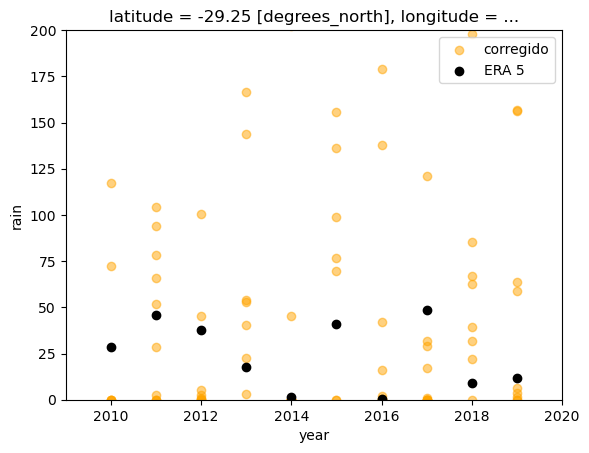

In [125]:
fig = plt.figure()
ds_corr_w2_smier[variable].plot.scatter(x='year', color='orange', alpha=0.5, label='corregido')
ds_era_w2_smier[variable].plot.scatter(x='year', color='k', label='ERA 5')
plt.axis([2009, 2020, 0, 200])
plt.legend()
plt.savefig(variable + '_corregido.jpg', dpi=200)